# Requirements

In [1]:
import nibabel as nib
import os
import numpy as np
import math
from collections.abc import Iterable
from math import log, cos, pi, floor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import monai
from monai.losses import DiceLoss
from torchvision.transforms import ToTensor
from tqdm import tqdm

import itk
import itkwidgets
from ipywidgets import interactive, IntSlider, ToggleButtons
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import deque
import time

# Model Implementation

In [2]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [3]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [4]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [5]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
""" Full assembly of the parts to form the complete network """

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.channel_factor = 4
        
        self.first_channel = int(64 / self.channel_factor)
        self.channel_list = np.array([self.first_channel, self.first_channel * 2, self.first_channel * 4, self.first_channel * 8, self.first_channel * 16])
        
        print("channel_list:\t", self.channel_list)
        
        self.inc = DoubleConv(n_channels, self.channel_list[0])
        self.down1 = Down(self.channel_list[0], self.channel_list[1])
        self.down2 = Down(self.channel_list[1], self.channel_list[2])
        self.down3 = Down(self.channel_list[2], self.channel_list[3])
        self.down4 = Down(self.channel_list[3], self.channel_list[4])
        self.up1 = Up(self.channel_list[4], self.channel_list[3])
        self.up2 = Up(self.channel_list[3], self.channel_list[2])
        self.up3 = Up(self.channel_list[2], self.channel_list[1])
        self.up4 = Up(self.channel_list[1], self.channel_list[0])
        self.outc = OutConv(self.channel_list[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Dataset and Data Generator

In [7]:
class BraTS(Dataset):
    def __init__(self, data_path, num_of_imgs, batch_factor=2, train_split=0.8, shuffleDataset=False, randomizeTrainSlices=False) -> None:
        super().__init__()
        self.data = np.memmap(data_path, dtype=np.float32, shape=(num_of_imgs, 8, 152, 192, 144), mode='r')
        self.batch_factor = batch_factor
        self.Idxs = np.arange(num_of_imgs*batch_factor)
        if shuffleDataset:
            self.shuffleTrainValSplit()
        self.trainIdxs = self.Idxs[:int(num_of_imgs*batch_factor*0.8)]
        self.valIdxs = self.Idxs[int(num_of_imgs*batch_factor*0.8):]
        self.state = None
        self.visualizationState = False
        
        self.randZoom = monai.transforms.RandZoomd(keys=['img', 'non_zero_ch', 'label'], prob=0.5, min_zoom=(1.0, 1.0, 1.0), max_zoom=(1.4, 1.4, 1.0), mode=['trilinear', 'nearest', 'nearest'], 
                                                  padding_mode='empty')
        self.randFlip0 = monai.transforms.RandFlipd(keys=['img', 'label'], prob=0.5, spatial_axis=0)
        self.randFlip1 = monai.transforms.RandFlipd(keys=['img', 'label'], prob=0.5, spatial_axis=1)
        
        self.randRoate = monai.transforms.RandRotated(keys=['img', 'label'], range_x=0, range_y=0, range_z=np.pi, prob=0.9, mode=["bilinear", "nearest"], padding_mode="zeros")
        self.randNoise = monai.transforms.RandGaussianNoise(prob=0.15, mean=0.0, std=np.random.uniform(low=0.0, high=0.33))
        self.randBlur = monai.transforms.RandGaussianSmooth(sigma_x=(0.16, 0.5), sigma_y=(0.16, 0.5), sigma_z=(0.16, 0.5), prob=0.15, approx='erf')
        
    def shuffleTrainValSplit(self):
        np.random.shuffle(self.Idxs)

    def trainMode(self):
        self.state = 'train'

    def valMode(self):
        self.state = 'val'
    
    def enableVisualizationMode(self):
        self.visualizationState = True
    
    def disableVisualizationMode(self):
        self.visualizationState = True
    
    def apply_batched_augmentation(self, func, img, gt=None, slice_wise=False):
        if isinstance(func, monai.transforms.spatial.dictionary.RandZoomd):
            if slice_wise:
                for idx in range(img.shape[-1]):
                    img[:-1, :, :, idx], img[[-1], :, :, idx], gt[:, :, :, idx] = tuple(func({'img': img[:-1, :, :, idx], 'non_zero_ch':img[[-1], :, :, idx] , 'label': gt[:, :, :, idx]}).values())
            else:
                img[:-1], img[[-1]], gt = tuple(func({'img': img[:-1], 'non_zero_ch':img[[-1]] , 'label': gt}).values())
            return img, gt

        elif isinstance(func, (monai.transforms.spatial.dictionary.RandRotated, monai.transforms.spatial.dictionary.RandFlipd)):
            if slice_wise:
                # Make sure to change range_z to range_x of random rotate if you wish to swith to slice_wise augmentation!
                for idx in range(img.shape[-1]):
                    img[:, :, :, idx], gt[:, :, :, idx] = tuple(func({'img': img[:, :, :, idx], 'label': gt[:, :, :, idx]}).values())
            else:
                    img, gt = tuple(func({'img': img, 'label': gt}).values())
            return img, gt
        
        elif isinstance(func, (monai.transforms.intensity.array.RandGaussianNoise, monai.transforms.intensity.array.RandGaussianSmooth)):
            if slice_wise:
                for idx in range(img.shape[-1]):
                    img[:-1, :, :, idx] = func(img[:-1, :, :, idx])
            else:
                    img[:-1] = func(img[:-1])
            return img
        

    def __len__(self):
        if self.state == 'train':
            return len(self.trainIdxs)
        elif self.state == 'val':
            return len(self.valIdxs)
        return len(self.Idxs)
    
    
    def __getitem__(self, idx_):
        
        num_of_slices = self.data.shape[-1]
        batch_size = num_of_slices // self.batch_factor
        
        if self.state=='train':
            idx = self.trainIdxs[idx_] // self.batch_factor
            batch_idx = self.trainIdxs[idx_] % self.batch_factor
        elif self.state=='val':
            idx = self.valIdxs[idx_] // self.batch_factor
            batch_idx = self.valIdxs[idx_] % self.batch_factor
        else:
            idx = self.Idxs[idx_] // self.batch_factor
            batch_idx = self.Idxs[idx_] % self.batch_factor
    
        if self.state=='train':
            b_img, b_gt = self.data[idx, :5, :, :, batch_idx*batch_size:(batch_idx+1)*batch_size], self.data[idx, 5:, :, :, batch_idx*batch_size:(batch_idx+1)*batch_size]
        else:
            b_img, b_gt = self.data[idx, :5, :, :, batch_idx*batch_size:(batch_idx+1)*batch_size], self.data[idx, 5:, :, :, batch_idx*batch_size:(batch_idx+1)*batch_size]
        b_img = np.copy(b_img)
        b_gt = np.copy(b_gt)

        # Augmentations
        if self.state=='train' and not self.visualizationState:
            # Zooming
            b_img, b_gt = self.apply_batched_augmentation(func=self.randZoom, img=b_img, gt=b_gt, slice_wise=False)

            # Axial flips
            b_img, b_gt = self.apply_batched_augmentation(func=self.randFlip0, img=b_img, gt=b_gt, slice_wise=False)
            b_img, b_gt = self.apply_batched_augmentation(func=self.randFlip1, img=b_img, gt=b_gt, slice_wise=False)
            
            # Rotatation
            b_img, b_gt = self.apply_batched_augmentation(func=self.randRoate, img=b_img, gt=b_gt, slice_wise=False)

            # Adding random Gaussian noise
            b_img = self.apply_batched_augmentation(func=self.randNoise, img=b_img, gt=b_gt, slice_wise=False)

            # Gaussian Blur
            b_img = self.apply_batched_augmentation(func=self.randBlur, img=b_img, slice_wise=False)
        
        # Deleting the empty pixels
        # (min_d, min_h, min_w), (max_d, max_h, max_w) = monai.transforms.utils.generate_spatial_bounding_box(img)
        # img = img[:, min_d:max_d, min_h:max_h, min_w:max_w]
        # gt = gt[:, min_d:max_d, min_h:max_h, min_w:max_w]
        
        # Fixing the input shape to the (channels, depth, height, width) order of Pytorch default
        b_img = np.transpose(b_img, (0, 3, 1, 2))
        b_gt = np.transpose(b_gt, (0, 3, 1, 2))
        
            
        # Transforming into PyTorch Tensor
        b_img = monai.transforms.ToTensor()(b_img).float()
        b_gt = monai.transforms.ToTensor()(b_gt).long()
        
        
        # divisible_pad = monai.transforms.DivisiblePad(k=16)
        # img, gt = divisible_pad(img), divisible_pad(gt)
        
        return b_img, b_gt

In [8]:
BraTS_dataset = BraTS("C:\Datasets\BraTS_2021_Numpy\dataset.dat", num_of_imgs=1251, train_split=0.8, batch_factor=2, shuffleDataset=True, randomizeTrainSlices=True)

In [9]:
BraTS_dataset.valMode()

In [10]:
i, g = BraTS_dataset.__getitem__(150)

In [11]:
i.shape

(5, 72, 152, 192)

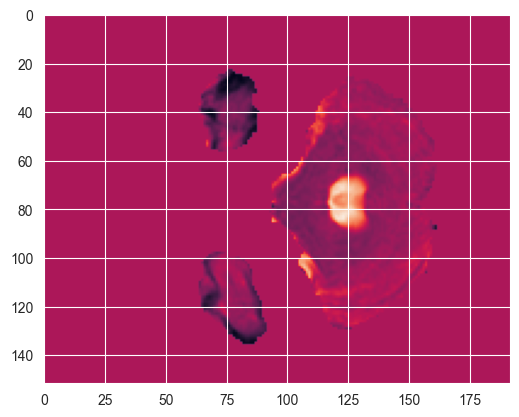

In [12]:
plt.imshow(i[2, 34, :, ])

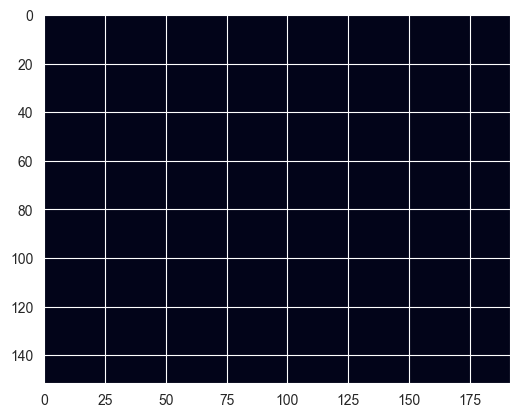

In [13]:
plt.imshow(g[0, 34, :, :])

# Utils

## Dataset Meta

In [14]:
# Name of the classes in the ground truth
classes_dict = {0: "Whole Tumor(WT)", 1: "Tumor Core(TC)", 2: "Enhancing Tumor(ET)"}

In [15]:
# Associated index of each modality in the input image
channel_order = {'t1': 0, 't1ce': 1,'t2': 2, 'flair': 3}

## Label Encoder-Decoder

In [16]:
def decode_label(mask, logits=False, batch=False):
    """
    Decodes the prediction masks into the original BraTS labels.
    [0:'WT', 1:'TC', 2:'ET'] --> [0:'BG', 1:'NCR', 2:'ED', 3:'ET']
    
    Parameters:
        - mask (np.ndarray): A 2D array of prediction mask in the one-hot encoded format.
        - logits (boolean): Specifies whether the inputs are logits.
        - batch (boolean): specifies whether the input is an encoded mask or a batch of encoded masks.
        
    Returns:
        - decoded_mask (np.ndarray): A 2D array representing the decoded mask in the one-hot encoded format.        
    """
    if batch:
        b, c, h, w = mask.shape
        decoded_mask = np.zeros(shape=(b, h, w))
    else:
        decoded_mask = np.zeros(shape=mask.shape[-2:])
    
    if logits:
        mask = torch.sigmoid(mask)

    if batch:
        decoded_mask = np.stack([np.where(mask[i, 0, :, :] < 0.5, 0, np.where(mask[i, 1, :, :] < 0.5, 2, np.where(mask[i, 2, :, :] < 0.5, 3, 1))) for i in range(b)], 0)
    else:
        decoded_mask = np.where(mask[0, :, :] < 0.5, 0, np.where(mask[1, :, :] < 0.5, 2, np.where(mask[2, :, :] < 0.5, 3, 1)))
    
    return decoded_mask


## Visualization

In [17]:
def plotter(train_history, val_history, lr_reduced_points, train_slice, val_slice, train_gt_slice, val_gt_slice, 
            train_pred_slice, val_pred_slice, train_cmat, val_cmat, epoch_num):
    # create objects
    fig = plt.figure(constrained_layout=False, figsize=(44, 33))
    gs = GridSpec(3, 4, figure=fig)

    ## create sub plots as grid
    # Sample train input image
    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(train_slice, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    ax.set_title("Train input image")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)

    # Sample validation input image
    ax = fig.add_subplot(gs[1, 0])
    im = ax.imshow(val_slice, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    ax.set_title("Validation input image")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)

    # Sample train groundtruth
    ax = fig.add_subplot(gs[0, 1])
    im = ax.imshow(train_gt_slice, cmap='jet', vmin=0, vmax=3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    ax.set_title("Train groundtruth")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)

    # Sample validation groundtruth
    ax = fig.add_subplot(gs[1, 1])
    im = ax.imshow(val_gt_slice, cmap='jet', vmin=0, vmax=3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    ax.set_title("Validation groundtruth")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)

    # Sample train Prediction
    ax = fig.add_subplot(gs[0, 2])
    im = ax.imshow(train_pred_slice, cmap='jet', vmin=0, vmax=3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    ax.set_title("Train Prediction")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)

    # Sample validation Prediction
    ax = fig.add_subplot(gs[1, 2])
    im = ax.imshow(val_pred_slice, cmap='jet', vmin=0, vmax=3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax)
    ax.set_title("Validation Prediction")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)

    # Train Confusion Matrix during an epoch
    ax = fig.add_subplot(gs[0, 3])
    ax.imshow(np.log(train_cmat + 1), cmap="Blues")
    for j in range(train_cmat.shape[0]):
        for k in range(train_cmat.shape[0]):
            plt.text(j, k, str(int(train_cmat[k, j])), c="red", va="center", ha="center", fontsize='xx-large')
    ax.set_title("Train Confusion Matrix")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)

    # Validation Confusion Matrix during an epoch
    ax = fig.add_subplot(gs[1, 3])
    ax.imshow(np.log(val_cmat + 1), cmap="Blues")
    for j in range(val_cmat.shape[0]):
        for k in range(val_cmat.shape[0]):
            ax.text(j, k, str(int(val_cmat[k, j])), c="red", va="center", ha="center", fontsize='xx-large')
    ax.set_title("Validation Confusion Matrix")
    ax.tick_params(labelbottom=False, labelleft=False)
    ax.grid(False)
    
    # Train/Validation Loss Plot
    ax = fig.add_subplot(gs[2, :])
    ax.plot(train_history)
    ax.plot(val_history)
    if len(lr_reduced_points)!=0:
        for p in lr_reduced_points:
            ax.axvline(x=p, ymin=0.05, ymax=0.95, color='purple', ls=':', lw=1)
    ax.set_title("Train/VaL Loss")
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.set_xticks(np.arange(1, max(len(train_history), len(val_history))+1))
    ax.legend(['train', 'val', 'lr reduction'], bbox_to_anchor=(1.0, 1), loc='upper left')
    
  
    fig.suptitle(f"Model Performance in Epoch {epoch_num+1}")
    plt.show()

## Performance Metrics

In [18]:
def confusion_matrix(ground_truth, predictions, num_classes, batch=False):
    """
    Computes the confusion matrix for a set of 2D arrays of ground truth and predictions.
    Both ground_truth and predictions are assumed to contain class indices.
    
    Parameters:
        - ground_truth (np.ndarray): A 2D/3D array of ground truth labels.
        - predictions (np.ndarray): A 2D/3D array of model predictions.
        - num_classes (int): The number of classes, including background.
        - batch (boolean) : Specifies whether the input is batched.
        
    Returns:
        - confusion_matrix (np.ndarray): A 2D array of size (num_classes, num_classes) representing the confusion matrix.
    """
    assert ground_truth.shape == predictions.shape, "Input shapes do not match"
    confusion_mat = np.zeros((num_classes, num_classes), dtype=np.int64)
    
    if batch:
        for i in range(ground_truth.shape[0]):
            for j in range(ground_truth.shape[1]):
                for k in range(ground_truth.shape[2]):
                        confusion_mat[ground_truth[i][j][k], predictions[i][j][k]] += 1
    else:
        for i in range(ground_truth.shape[0]):
            for j in range(ground_truth.shape[1]):
                        confusion_mat[ground_truth[i][j], predictions[i][j]] += 1
    return confusion_mat

In [19]:
def iou(confusion_matrix):
    """
    Computes the Intersection over Union (IoU) metric for each class given a multi-class confusion matrix.
    
    Parameters:
        confusion_matrix (np.ndarray): A 2-dimensional Numpy array representing the confusion matrix. The rows represent the true labels and the columns represent the predicted labels.
    
    Returns:
        list: A list of IoU values, one for each class excluding the background class.
    """
    ious = []
    for i in range(confusion_matrix.shape[0]):
        # True Positive (tp)
        tp = confusion_matrix[i, i]
        # False Negative (fn)
        fn = confusion_matrix[i, :].sum() - tp
        # False Positive (fp)
        fp = confusion_matrix[:, i].sum() - tp
        # Intersection over Union (IoU)
        iou = tp / (tp + fn + fp)
        ious.append(iou)
    return np.array(ious)

In [20]:
def dice_score(confusion_matrix):
    """
    Computes the Dice Similarity Coefficient (DSC) metric for each class given a multi-class confusion matrix.
    
    Parameters:
        confusion_matrix (np.ndarray): A 2-dimensional Numpy array representing the confusion matrix. The rows represent the true labels and the columns represent the predicted labels.
    
    Returns:
        list: A list of DSC values, one for each class.
    """
    dscs = []
    for i in range(confusion_matrix.shape[0]):
        # True Positive (tp)
        tp = confusion_matrix[i, i]
        # False Negative (fn)
        fn = confusion_matrix[i, :].sum() - tp
        # False Positive (fp)
        fp = confusion_matrix[:, i].sum() - tp
        # Dice Similarity Coefficient (DSC)
        dsc = 2 * tp / (2 * tp + fn + fp)
        dscs.append(dsc)
    return np.array(dscs)


## Loss function

In [21]:
class Loss(nn.Module):
    def __init__(self, class_weights, dice_weight=1.0, bce_loss_weights=[1.0, 1.0, 1.0]):
        super(Loss, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce1 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights[0]))
        self.ce2 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights[1]))
        self.ce3 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(class_weights[2])) 
        
        self.dice_weight = dice_weight
        self.bce_loss_weights = bce_loss_weights

    def _loss(self, p, y):
        return self.dice_weight*self.dice(p, y) + self.bce_loss_weights[0]*self.ce1(p[:, 0, :, :], y[:, 0, :, :].float()) + \
                self.bce_loss_weights[1]*self.ce2(p[:, 1, :, :], y[:, 1, :, :].float()) + self.bce_loss_weights[2]*self.ce3(p[:, 2, : , :], y[:, 2, : , :].float())

    def forward(self, p, y):
        return self._loss(p, y)

## Learning rate scheduler

In [22]:
from torch.optim.lr_scheduler import _LRScheduler


class CyclicCosineDecayLR(_LRScheduler):
    def __init__(self,
                 optimizer,
                 init_decay_epochs,
                 min_decay_lr,
                 restart_interval=None,
                 restart_interval_multiplier=None,
                 restart_lr=None,
                 warmup_epochs=None,
                 warmup_start_lr=None,
                 last_epoch=-1,
                 verbose=False):
        """
        Initialize new CyclicCosineDecayLR object.

        :param optimizer: (Optimizer) - Wrapped optimizer.
        :param init_decay_epochs: (int) - Number of initial decay epochs.
        :param min_decay_lr: (float or iterable of floats) - Learning rate at the end of decay.
        :param restart_interval: (int) - Restart interval for fixed cycles.
            Set to None to disable cycles. Default: None.
        :param restart_interval_multiplier: (float) - Multiplication coefficient for geometrically increasing cycles.
            Default: None.
        :param restart_lr: (float or iterable of floats) - Learning rate when cycle restarts.
            If None, optimizer's learning rate will be used. Default: None.
        :param warmup_epochs: (int) - Number of warmup epochs. Set to None to disable warmup. Default: None.
        :param warmup_start_lr: (float or iterable of floats) - Learning rate at the beginning of warmup.
            Must be set if warmup_epochs is not None. Default: None.
        :param last_epoch: (int) - The index of the last epoch. This parameter is used when resuming a training job. Default: -1.
        :param verbose: (bool) - If True, prints a message to stdout for each update. Default: False.
        """

        if not isinstance(init_decay_epochs, int) or init_decay_epochs < 1:
            raise ValueError("init_decay_epochs must be positive integer, got {} instead".format(init_decay_epochs))

        if isinstance(min_decay_lr, Iterable) and len(min_decay_lr) != len(optimizer.param_groups):
            raise ValueError("Expected len(min_decay_lr) to be equal to len(optimizer.param_groups), "
                             "got {} and {} instead".format(len(min_decay_lr), len(optimizer.param_groups)))

        if restart_interval is not None and (not isinstance(restart_interval, int) or restart_interval < 1):
            raise ValueError("restart_interval must be positive integer, got {} instead".format(restart_interval))

        if restart_interval_multiplier is not None and \
                (not isinstance(restart_interval_multiplier, float) or restart_interval_multiplier <= 0):
            raise ValueError("restart_interval_multiplier must be positive float, got {} instead".format(
                restart_interval_multiplier))

        if isinstance(restart_lr, Iterable) and len(restart_lr) != len(optimizer.param_groups):
            raise ValueError("Expected len(restart_lr) to be equal to len(optimizer.param_groups), "
                             "got {} and {} instead".format(len(restart_lr), len(optimizer.param_groups)))

        if warmup_epochs is not None:
            if not isinstance(warmup_epochs, int) or warmup_epochs < 1:
                raise ValueError(
                    "Expected warmup_epochs to be positive integer, got {} instead".format(type(warmup_epochs)))

            if warmup_start_lr is None:
                raise ValueError("warmup_start_lr must be set when warmup_epochs is not None")

            if not (isinstance(warmup_start_lr, float) or isinstance(warmup_start_lr, Iterable)):
                raise ValueError("warmup_start_lr must be either float or iterable of floats, got {} instead".format(
                    warmup_start_lr))

            if isinstance(warmup_start_lr, Iterable) and len(warmup_start_lr) != len(optimizer.param_groups):
                raise ValueError("Expected len(warmup_start_lr) to be equal to len(optimizer.param_groups), "
                                 "got {} and {} instead".format(len(warmup_start_lr), len(optimizer.param_groups)))

        group_num = len(optimizer.param_groups)
        self._warmup_start_lr = [warmup_start_lr] * group_num if isinstance(warmup_start_lr, float) else warmup_start_lr
        self._warmup_epochs = 0 if warmup_epochs is None else warmup_epochs
        self._init_decay_epochs = init_decay_epochs
        self._min_decay_lr = [min_decay_lr] * group_num if isinstance(min_decay_lr, float) else min_decay_lr
        self._restart_lr = [restart_lr] * group_num if isinstance(restart_lr, float) else restart_lr
        self._restart_interval = restart_interval
        self._restart_interval_multiplier = restart_interval_multiplier
        super(CyclicCosineDecayLR, self).__init__(optimizer, last_epoch, verbose=verbose)

    def get_lr(self):

        if self._warmup_epochs > 0 and self.last_epoch < self._warmup_epochs:
            return self._calc(self.last_epoch,
                              self._warmup_epochs,
                              self._warmup_start_lr,
                              self.base_lrs)

        elif self.last_epoch < self._init_decay_epochs + self._warmup_epochs:
            return self._calc(self.last_epoch - self._warmup_epochs,
                              self._init_decay_epochs,
                              self.base_lrs,
                              self._min_decay_lr)
        else:
            if self._restart_interval is not None:
                if self._restart_interval_multiplier is None:
                    cycle_epoch = (self.last_epoch - self._init_decay_epochs - self._warmup_epochs) % self._restart_interval
                    lrs = self.base_lrs if self._restart_lr is None else self._restart_lr
                    return self._calc(cycle_epoch,
                                      self._restart_interval,
                                      lrs,
                                      self._min_decay_lr)
                else:
                    n = self._get_n(self.last_epoch - self._warmup_epochs - self._init_decay_epochs)
                    sn_prev = self._partial_sum(n)
                    cycle_epoch = self.last_epoch - sn_prev - self._warmup_epochs - self._init_decay_epochs
                    interval = self._restart_interval * self._restart_interval_multiplier ** n
                    lrs = self.base_lrs if self._restart_lr is None else self._restart_lr
                    return self._calc(cycle_epoch,
                                      interval,
                                      lrs,
                                      self._min_decay_lr)
            else:
                return self._min_decay_lr

    def _calc(self, t, T, lrs, min_lrs):
        return [min_lr + (lr - min_lr) * ((1 + cos(pi * t / T)) / 2)
                for lr, min_lr in zip(lrs, min_lrs)]

    def _get_n(self, epoch):
        _t = 1 - (1 - self._restart_interval_multiplier) * epoch / self._restart_interval
        return floor(log(_t, self._restart_interval_multiplier))

    def _partial_sum(self, n):
        return self._restart_interval * (1 - self._restart_interval_multiplier ** n) / (
                    1 - self._restart_interval_multiplier)


## Early Stopper

In [23]:
class EarlyStopper():
    """
    Initialize the early stopping class. 
    Args:
        patience (int): Number of times the validation loss is allowed to increase before stopping the training
        min_delta (float): Minimum change in validation loss required to consider it as an improvement
        use_moving_average (bool): Flag to indicate whether to use moving average or fixed threshold technique
        moving_average_window (int): Number of validation loss values to use for calculating the moving average
    """
    def __init__(self, patience=1, min_delta=0, use_moving_average=True, moving_average_window=10):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.use_moving_average = use_moving_average
        self.moving_average_window = moving_average_window
        self.moving_average_loss = 0
        self.loss_values = deque(maxlen=moving_average_window)
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if self.use_moving_average:
            self.loss_values.append(validation_loss)
            self.moving_average_loss = np.mean(self.loss_values)
            if validation_loss > (self.moving_average_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            else:
                self.counter = 0
                return False
        else:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                return False
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    self.counter = 0
                    return True
                return False
        return False


# Training

## Training Configurations

In [24]:
EPOCHS = 96
BATCHING_FACTOR = 2
STOP_ITER = math.inf
INITIAL_LR = 0.01

NUMBER_OF_CLASSES = 3
NUMBER_OF_CHANNELS = 5
CLASS_WEIGHTS = [ 0.9771647118678108 ,  0.991492510867646 ,  0.9965959193080477 ]
BCE_WEIGHTS = [1.5, 1, 1]
DICE_WEIGHT = 1

TRAIN_SPLIT = 0.8
SHUFFLE_DATASET = True
SHUFFLE_TRAIN_SLICES = True 

TRAIN_VISUAL_SLICE = 38
VAL_VISUAL_SLICE = 10

In [25]:
# Name of the images to visualize during training
train_visualization = 'BraTS2021_00000' #'BraTS2021_01661'
val_visualization = 'BraTS2021_00006' #'BraTS2021_01657'
sample_modality = 't1'

## Required Varriables

In [26]:
model = UNet(n_channels=NUMBER_OF_CHANNELS, n_classes=NUMBER_OF_CLASSES)

channel_list:	 [ 16  32  64 128 256]


In [27]:
loss = Loss(class_weights=CLASS_WEIGHTS, dice_weight=DICE_WEIGHT, bce_loss_weights=BCE_WEIGHTS)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=INITIAL_LR, weight_decay=0.0001)

In [29]:
lr_scheduler = CyclicCosineDecayLR(optimizer, 
                                init_decay_epochs=EPOCHS,
                                min_decay_lr=0.001,
                                warmup_epochs=1,
                                warmup_start_lr=0.0001)

In [30]:
early_stopping = EarlyStopper(patience=8, min_delta=0.0001, use_moving_average=True, moving_average_window=5)

In [31]:
BraTS_dataset = BraTS("C:\Datasets\BraTS_2021_Numpy\dataset.dat", num_of_imgs=1251, batch_factor=BATCHING_FACTOR, train_split=TRAIN_SPLIT, shuffleDataset=SHUFFLE_DATASET, randomizeTrainSlices=SHUFFLE_TRAIN_SLICES)

In [32]:
data_loader = DataLoader(BraTS_dataset, batch_size=1)

In [33]:
# Keeps track of the train and val losses during training
train_loss_history = []
val_loss_history = []

# Keeps track of the epochs when lr is reduced
lr_tracker = []

### Change the TRAIN_VISUAL_SLICE and VAL_VISUAL_SLICE

In [38]:
if torch.cuda.is_available():
    model = model.cuda()
train_confusion_matrix = np.zeros((4, 4))
val_confusion_matrix = np.zeros((4, 4))


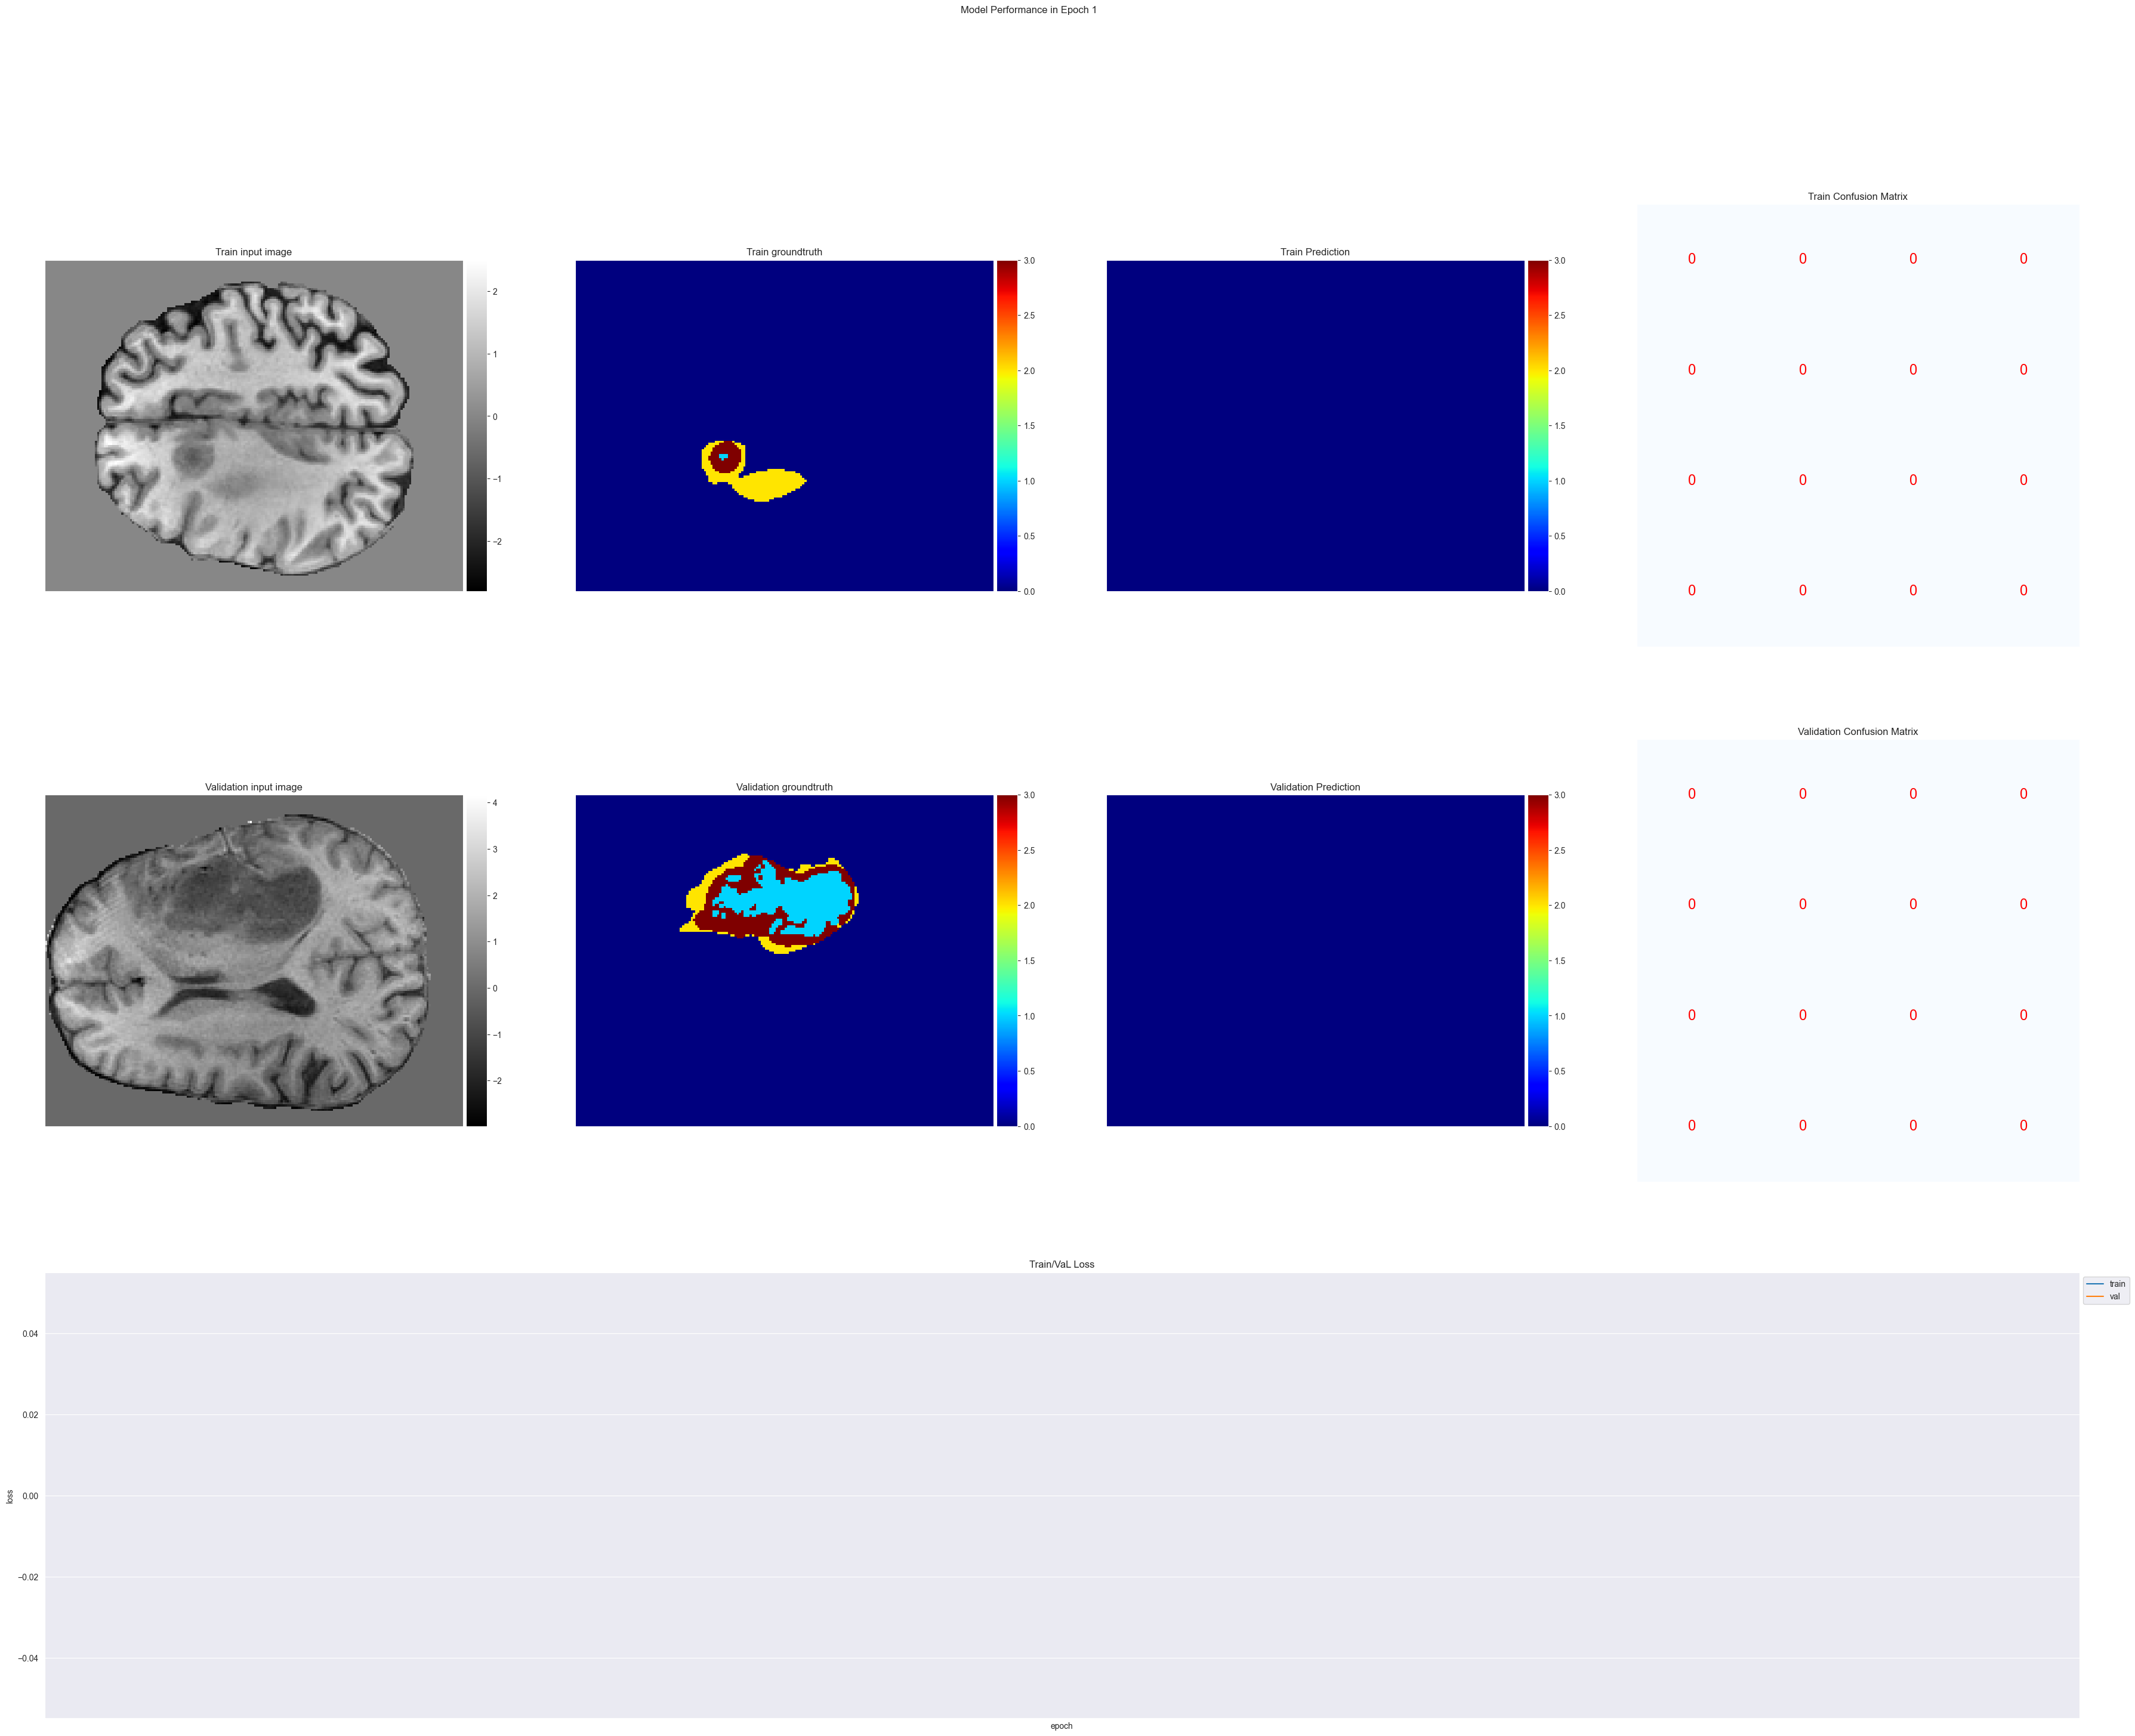

In [55]:
TRAIN_VISUAL_SLICE = 27
VAL_VISUAL_SLICE = 10

# Passing the visualization images to the model
BraTS_dataset.enableVisualizationMode()


BraTS_dataset.trainMode()
sample_train, train_target = BraTS_dataset.__getitem__(1)
train_target = train_target[:, TRAIN_VISUAL_SLICE, :, :]
sample_train = sample_train[:, TRAIN_VISUAL_SLICE, :, :]
sample_train = sample_train.unsqueeze(0).float()

BraTS_dataset.valMode()
sample_val, val_target = BraTS_dataset.__getitem__(2)
val_target = val_target[:, VAL_VISUAL_SLICE, :, :]
sample_val = sample_val[:, VAL_VISUAL_SLICE, :, :]
sample_val = sample_val.unsqueeze(0).float()

train_pred = None
val_pred = None

if torch.cuda.is_available():
    sample_train, sample_val = sample_train.cuda(), sample_val.cuda()

with torch.no_grad():
    model.eval()
    train_pred = model(sample_train)
    val_pred = model(sample_val)

sample_train = sample_train.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
sample_val = sample_val.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
train_target = decode_label(train_target)
val_target = decode_label(val_target)
train_pred = decode_label(train_pred.squeeze(0), logits=True)
val_pred = decode_label(val_pred.squeeze(0), logits=True)

# Plotting Model Performance
plotter(train_loss_history, val_loss_history, [], sample_train, sample_val, 
        train_target, val_target, train_pred, val_pred, train_confusion_matrix, val_confusion_matrix, 0)

In [ ]:
best_loss = math.inf

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(EPOCHS):
    BraTS_dataset.disableVisualizationMode()

    # Metrics
    train_confusion_matrix = np.zeros((4, 4))
    val_confusion_matrix = np.zeros((4, 4))
    train_iou = [0]*(NUMBER_OF_CLASSES-1) # Excluding background
    val_iou = [0]*(NUMBER_OF_CLASSES-1)
    train_dice = [0]*(NUMBER_OF_CLASSES) # Including background
    val_dice = [0]*(NUMBER_OF_CLASSES)

    # Training
    print('*** Training Epoch %d ***'%(epoch+1))
    model.train(True)
    BraTS_dataset.trainMode()
    torch.set_grad_enabled(True)
    total_train_loss = 0
    train_counter = 0

    # Loop through the batches of images and labels
    for img, label in tqdm(data_loader):
        TOTAL_NUMBER_OF_SLICES = img.shape[-3]
        img = img.squeeze(0).transpose(1, 0) # Making the depth dimension as the batchsize
        label = label.squeeze(0).transpose(1, 0) 

        lr_tracker.append(lr_scheduler.get_lr())

        if torch.cuda.is_available():
            img, label = img.cuda(), label.cuda()
        optimizer.zero_grad()
        pred = model(img)
        batch_loss = loss(pred, label)
        batch_loss.backward()
        optimizer.step()
        # cosine Learning rate scheduling
        lr_scheduler.step() 
        total_train_loss += batch_loss.item() 
        decoded_pred = decode_label(pred, logits=True, batch=True)
        decoded_label = decode_label(label, batch=True)
        # Confusion matrix calculation
        train_confusion_matrix += confusion_matrix(decoded_label, decoded_pred, num_classes=4, batch=True)
        # Tracking the learning rate for plotting
        lr_tracker.append(lr_scheduler.optimizer.param_groups[0]["lr"])
        train_counter+=1
        if train_counter > STOP_ITER: break
        break

    final_train_loss = total_train_loss/len(data_loader)
    train_iou = np.array(iou(train_confusion_matrix) * 10000, dtype=np.int32) / 100
    train_dice = np.array(dice_score(train_confusion_matrix) * 10000, dtype=np.int32) / 100
    train_loss_history.append(final_train_loss)
    
    print('Epoch: %d  Train Loss: %.6f \n' %(epoch+1, final_train_loss))
    print('Epoch: %d  Train Mean-IoU Including BG: %.4f \n' %(epoch+1,  train_iou.mean()))
    print('Epoch: %d  Train Mean-IoU Excluding BG: %.4f \n' %(epoch+1,  train_iou[1:].mean()))
    print('Epoch: %d  Train Mean Dice Score Including BG: %.4f \n' %(epoch+1, train_dice.mean()))
    print('Epoch: %d  Train Mean Dice Score Excluding BG: %.4f \n' %(epoch+1, train_dice[1:].mean()))
    print(f'Epoch: {epoch+1}  Class-specific Train IoU--> BG: {train_iou[0]}%,\tNCR: {train_iou[1]}%,\tED: {train_iou[2]}%,\tET: {train_iou[3]}% \n')
    print(f'Epoch: {epoch+1}  Class-specific Train Dice Score--> BG: {train_dice[0]}%,\tNCR: {train_dice[1]}%,\tED: {train_dice[2]}%,\tET: {train_dice[3]}% \n')


    # Validation
    print('*** Validation Epoch %d ***'%(epoch+1))
    model.eval()
    BraTS_dataset.valMode()
    torch.set_grad_enabled(False)
    total_val_loss = 0
    val_counter=0
    
    for img, label in tqdm(data_loader):
        TOTAL_NUMBER_OF_SLICES = img.shape[-3]
        img = img.squeeze(0).transpose(1, 0)
        label = label.squeeze(0).transpose(1, 0)
        if torch.cuda.is_available():
            img, label = img.cuda(), label.cuda()
        pred = model(img)
        batch_loss = loss(pred, label)
        total_val_loss += batch_loss.item()
        decoded_pred = decode_label(pred, logits=True, batch=True)
        decoded_label = decode_label(label, batch=True)
        # Confusion matrix calculation
        val_confusion_matrix += confusion_matrix(decoded_label, decoded_pred, num_classes=4, batch=True)
        
        val_counter+=1
        if val_counter > STOP_ITER: break
        break
    
    final_val_loss = total_val_loss/len(data_loader)
    val_iou = np.array(iou(val_confusion_matrix) * 10000, dtype=np.int32) / 100
    val_dice = np.array(dice_score(val_confusion_matrix) * 10000, dtype=np.int32) / 100
    val_loss_history.append(final_val_loss)
    
    
    print('Epoch: %d  Validation Loss: %.6f \n' %(epoch+1, final_val_loss))
    print('Epoch: %d  Validation Mean-IoU Including BG: %.4f \n' %(epoch+1,  val_iou.mean()))
    print('Epoch: %d  Validation Mean-IoU Excluding BG: %.4f \n' %(epoch+1,  val_iou[1:].mean()))
    print('Epoch: %d  Validation Mean Dice Score Including BG: %.4f \n' %(epoch+1, val_dice.mean()))
    print('Epoch: %d  Validation Mean Dice Score Excluding BG: %.4f \n' %(epoch+1, val_dice[1:].mean()))
    print(f'Epoch: {epoch+1}  Class-specific Validation IoU--> BG: {val_iou[0]}%,\tNCR: {val_iou[1]}%,\tED: {val_iou[2]}%,\tET: {val_iou[3]}% \n')
    print(f'Epoch: {epoch+1}  Class-specific Validation Dice Score--> BG: {val_dice[0]}%,\tNCR: {val_dice[1]}%,\tED: {val_dice[2]}%,\tET: {val_dice[3]}% \n')


    # Early Stopping
    if early_stopping.early_stop(final_val_loss):
        # break
        pass
    
    # Saving the best Model
    if (final_val_loss) < best_loss:
        torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'train_loss': total_train_loss,
          'val_loss': final_val_loss,
        }, "./2D_U_Net_Memap_zoomAdded_cosineScheduler_newClassandLossWeights-Copy1_best.pth")
        best_loss = final_val_loss
      
    

    del img, label
    
    # Passing the visualization images to the model
    BraTS_dataset.enableVisualizationMode()

 
    BraTS_dataset.trainMode()
    sample_train, train_target = BraTS_dataset.__getitem__(1)
    train_target = train_target[:, TRAIN_VISUAL_SLICE, :, :]
    sample_train = sample_train[:, TRAIN_VISUAL_SLICE, :, :]
    sample_train = sample_train.unsqueeze(0).float()

    BraTS_dataset.valMode()
    sample_val, val_target = BraTS_dataset.__getitem__(2)
    val_target = val_target[:, VAL_VISUAL_SLICE, :, :]
    sample_val = sample_val[:, VAL_VISUAL_SLICE, :, :]
    sample_val = sample_val.unsqueeze(0).float()

    train_pred = None
    val_pred = None

    if torch.cuda.is_available():
        sample_train, sample_val = sample_train.cuda(), sample_val.cuda()

    with torch.no_grad():
        model.eval()
        train_pred = model(sample_train)
        val_pred = model(sample_val)

    sample_train = sample_train.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
    sample_val = sample_val.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
    train_target = decode_label(train_target)
    val_target = decode_label(val_target)
    train_pred = decode_label(train_pred.squeeze(0), logits=True)
    val_pred = decode_label(val_pred.squeeze(0), logits=True)

    # Plotting Model Performance
    plotter(train_loss_history, val_loss_history, [], sample_train, sample_val, 
            train_target, val_target, train_pred, val_pred, train_confusion_matrix, val_confusion_matrix, epoch)
        
    

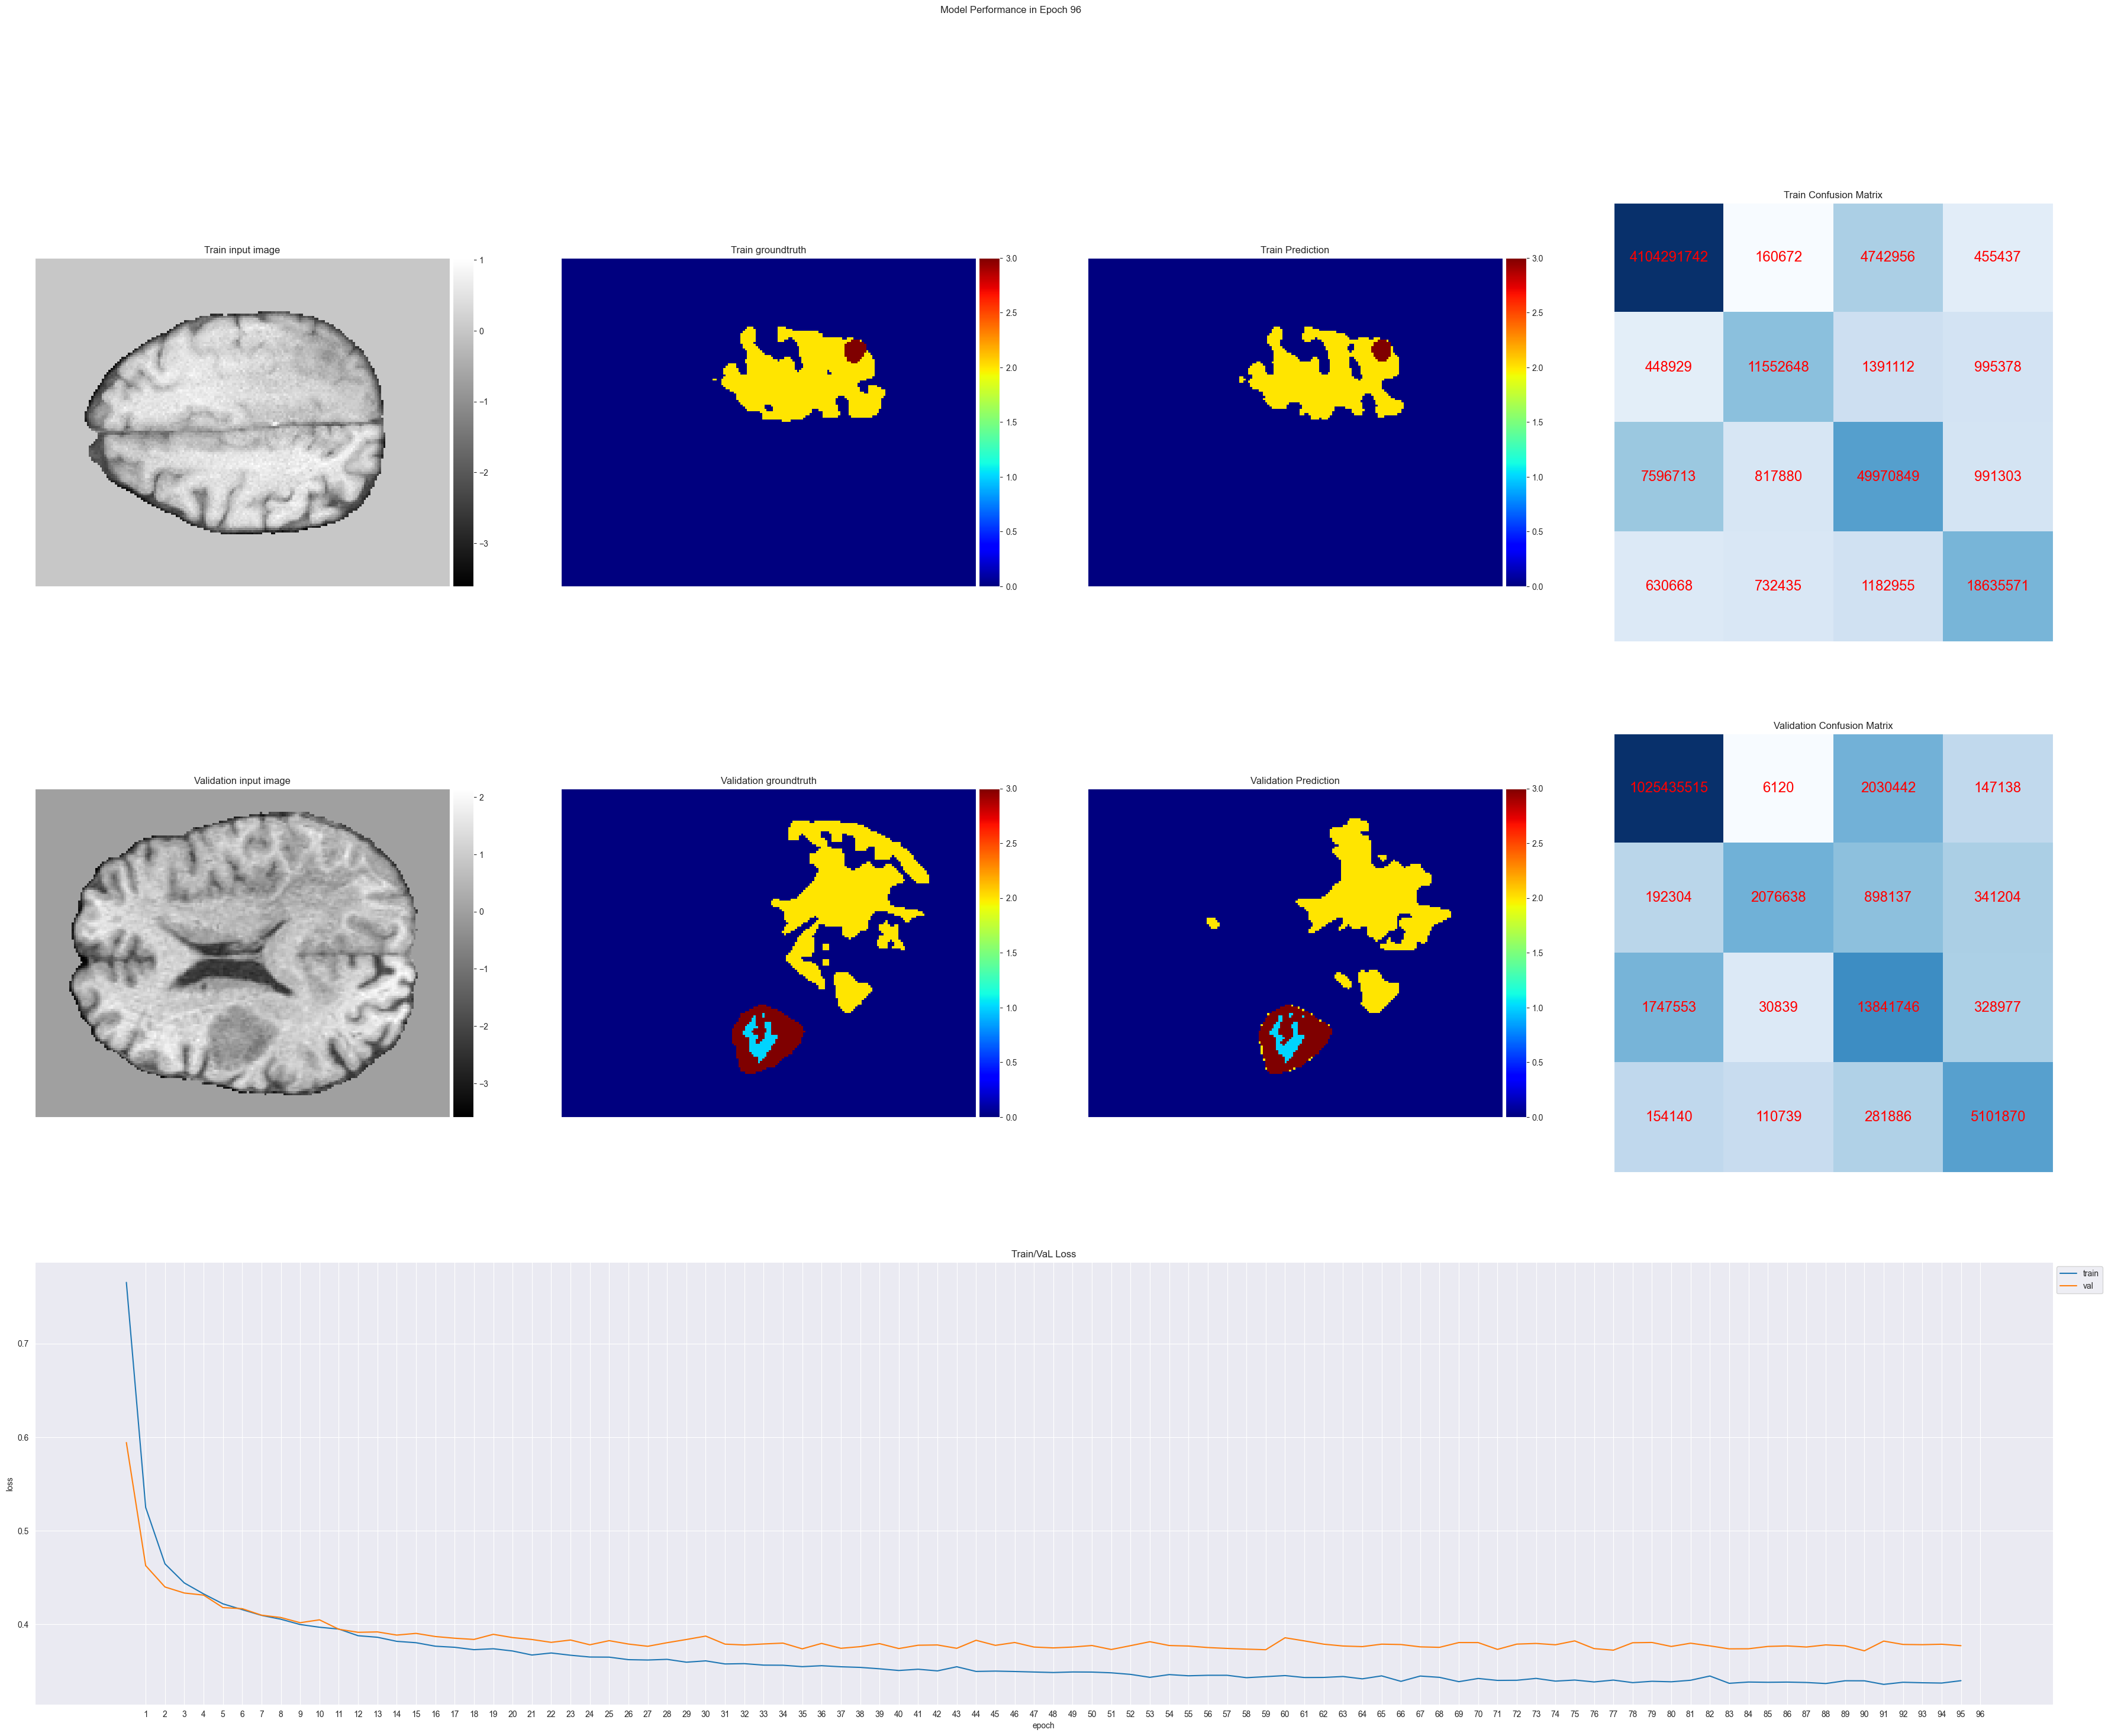

In [58]:
# BraTS_dataset.enableVisualizationMode()


# BraTS_dataset.trainMode()
# sample_train, train_target = BraTS_dataset.__getitem__(1)
# train_target = train_target[:, TRAIN_VISUAL_SLICE, :, :]
# sample_train = sample_train[:, TRAIN_VISUAL_SLICE, :, :]
# sample_train = sample_train.unsqueeze(0).float()

# BraTS_dataset.valMode()
# sample_val, val_target = BraTS_dataset.__getitem__(2)
# val_target = val_target[:, VAL_VISUAL_SLICE, :, :]
# sample_val = sample_val[:, VAL_VISUAL_SLICE, :, :]
# sample_val = sample_val.unsqueeze(0).float()

# train_pred = None
# val_pred = None

# if torch.cuda.is_available():
#     sample_train, sample_val = sample_train.cuda(), sample_val.cuda()

# with torch.no_grad():
#     model.eval()
#     train_pred = model(sample_train)
#     val_pred = model(sample_val)

# sample_train = sample_train.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
# sample_val = sample_val.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
# train_target = decode_label(train_target)
# val_target = decode_label(val_target)
# train_pred = decode_label(train_pred.squeeze(0), logits=True)
# val_pred = decode_label(val_pred.squeeze(0), logits=True)

# # Plotting Model Performance
# plotter(train_loss_history, val_loss_history, [], sample_train, sample_val, 
#         train_target, val_target, train_pred, val_pred, train_confusion_matrix, val_confusion_matrix, epoch)


In [35]:
############## Visualize the encoding to decide which tree to use.
# BraTS_dataset.shuffle = False
# BraTS_dataset.setVisualizationMode(True)

# BraTS_dataset.trainMode()
# train_idx = BraTS_dataset.trainNames.index(train_visualization)
# sample_train, train_target = BraTS_dataset.__getitem__(train_idx)
# train_target = train_target[:, TRAIN_VISUAL_SLICE, :, :]
# sample_train = sample_train[:, TRAIN_VISUAL_SLICE, :, :]
# sample_train = sample_train.unsqueeze(0).float()

# BraTS_dataset.valMode()
# val_idx = BraTS_dataset.valNames.index(val_visualization)
# sample_val, val_target = BraTS_dataset.__getitem__(val_idx)
# val_target = val_target[:, VAL_VISUAL_SLICE, :, :]
# sample_val = sample_val[:, VAL_VISUAL_SLICE, :, :]
# sample_val = sample_val.unsqueeze(0).float()

# train_pred = None
# val_pred = None

# if torch.cuda.is_available():
#     sample_train, sample_val = sample_train.cuda(), sample_val.cuda()

# with torch.no_grad():
#     model.eval()
#     train_pred = model(sample_train)
#     val_pred = model(sample_val)

# sample_train = sample_train.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
# sample_val = sample_val.squeeze(0).cpu().numpy()[channel_order[sample_modality], :, :]
# train_target = decode_label(train_target)
# val_target = decode_label(val_target)
# train_pred = decode_label(train_pred.squeeze(0), logits=True)
# val_pred = decode_label(val_pred.squeeze(0), logits=True)

# plotter(train_loss_history, val_loss_history, lr_tracker, sample_train, sample_val, 
#         train_target, val_target, train_pred, val_pred, train_confusion_matrix, val_confusion_matrix, epoch)

In [36]:
# base_folder = "C:/Datasets/BraTS-2021/BraTS2021_Training_Data"
# name_l = os.listdir(base_folder)

In [37]:
# class_sum = np.zeros((4,), np.int64)
# for name in tqdm(name_l):
#     #### Image path
#     t1_img = os.path.join(base_folder, name, f"{name}_t1.nii.gz")
#     t1ce_img = os.path.join(base_folder, name, f"{name}_t1ce.nii.gz")
#     t2_img = os.path.join(base_folder, name, f"{name}_t2.nii.gz")
#     flair_img = os.path.join(base_folder, name, f"{name}_flair.nii.gz")
#     gt = os.path.join(base_folder, name, f"{name}_seg.nii.gz")

#     #### Reading Images
#     t1_img = nib.load(t1_img).get_fdata()
#     t1ce_img = nib.load(t1ce_img).get_fdata()
#     t2_img = nib.load(t2_img).get_fdata()
#     flair_img = nib.load(flair_img).get_fdata()
#     gt = nib.load(gt).get_fdata()
#     non_zero_mask = ((t1_img + t1ce_img + t2_img + flair_img) == 0) ^ 1
#     img = np.stack([t1_img, t1ce_img, t2_img, flair_img, non_zero_mask], axis=0)
#     (min_d, min_h, min_w), (max_d, max_h, max_w) = monai.transforms.utils.generate_spatial_bounding_box(img)
#     img = img[:, min_d:max_d, min_h:max_h, min_w:max_w]
#     gt = gt[min_d:max_d, min_h:max_h, min_w:max_w]
#     class_sum[0] += np.where(gt==0, 1, 0).sum(dtype=np.int64)
#     class_sum[1] += np.where(gt==1, 1, 0).sum(dtype=np.int64)
#     class_sum[2] += np.where(gt==2, 1, 0).sum(dtype=np.int64)
#     class_sum[3] += np.where(gt==4, 1, 0).sum(dtype=np.int64)
# print(class_sum)

In [38]:
# count_bg = class_sum[0]
# count_ncr = class_sum[1]
# count_ed = class_sum[2]
# count_et = class_sum[3]
# ws1 = (count_bg) / np.sum(class_sum)
# ws2 = (count_bg + count_ed) / np.sum(class_sum)
# ws3 = (count_bg + count_ed + count_et) / np.sum(class_sum)
# print("[", ws1, ", ", ws2, ", ", ws3, "]")

In [39]:
# new_weights = 1 / class_sum
# new_weights /= np.mean(new_weights)
# print(new_weights)

In [40]:
# train_target.shape

In [41]:
# len(BraTS_dataset.valNames)